Processing files with parameters: type=act, img=beta, mask=VS, denoise=base
Data saved to multiecho_data_act_beta_VS_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
7     10017        64  245.809879  -33.401003  -59.411007 -192.291345   
0     10024        64   51.505184  216.723902  -43.077833  301.659488   
19    10035        64   63.785181   -4.770408   58.702194  256.401259   
20    10041        64  116.056601    1.490057   49.606862  109.906853   
26    10043        64  -25.623388  355.151709  249.998314  374.413217   

        mb3me4      mb6me4  
7    94.342661 -455.284310  
0   228.203450  215.914338  
19   39.646107  -12.061903  
20   39.833826  244.574431  
26  230.452505   96.114009  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_act_beta_VS_base.png'


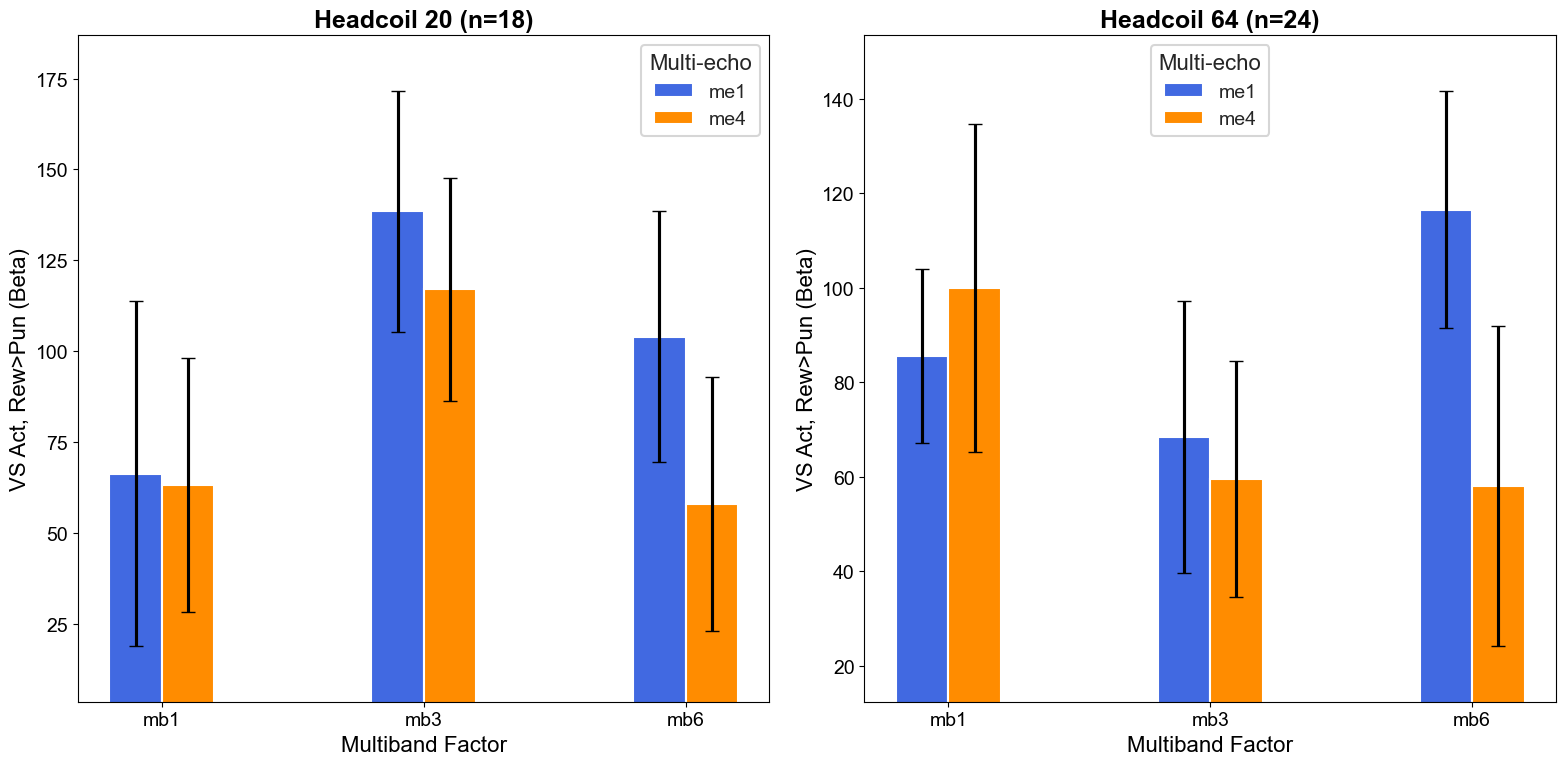

In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "beta"  # e.g., "beta"
MASK_VALUE = "VS"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS Act, Rew>Pun (Beta)', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=act, img=zstat, mask=VS, denoise=base
Data saved to multiecho_data_act_zstat_VS_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
5     10017        64  0.198120 -0.070155 -0.176612 -0.145148  0.117297   
14    10024        64  0.159562  0.645702 -0.215139  0.541546  0.716730   
25    10035        64  0.165379  0.012742  0.188826  0.507736  0.109783   
28    10041        64  0.207848  0.016244  0.165816  0.171276  0.108688   
3     10043        64  0.039013  1.243344  1.105695  0.471506  0.697493   

      mb6me4  
5  -0.575953  
14  0.747719  
25 -0.033795  
28  0.790779  
3   0.303748  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_act_zstat_VS_base.png'


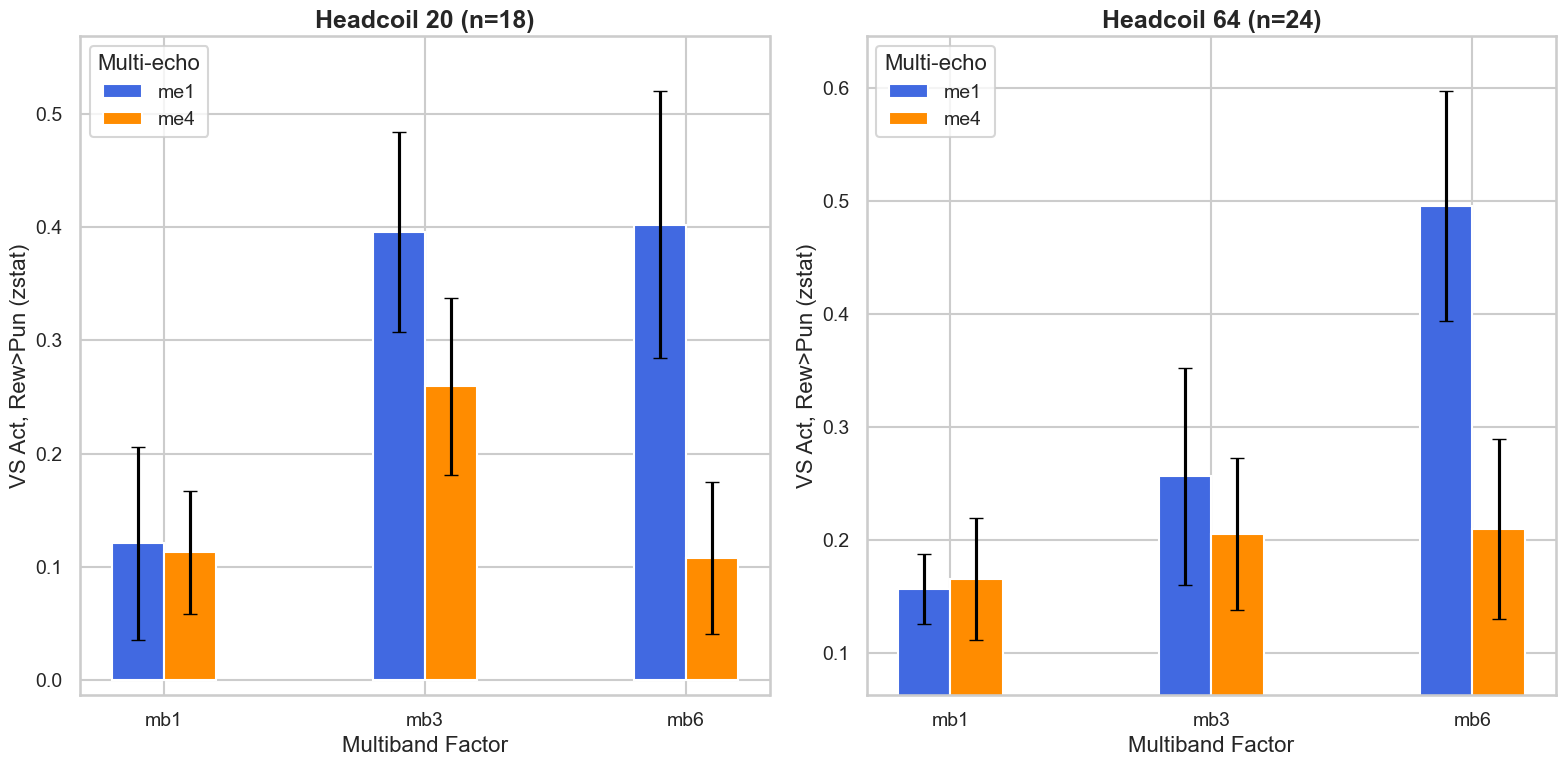

In [5]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "zstat"  # e.g., "beta"
MASK_VALUE = "VS"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS Act, Rew>Pun (zstat)', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=act, img=tsnr, mask=VS, denoise=base
Data saved to multiecho_data_act_tsnr_VS_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
9     10017        64   98.468008  101.082365   89.113103  126.669046   
30    10024        64   89.921802  101.068596  101.829283  111.832313   
36    10035        64  114.323338  105.055642   90.190901  138.917720   
12    10041        64   94.474556   91.302075   76.609985   98.700391   
33    10043        64  114.856834  105.939600  108.623690  124.660089   

        mb3me4     mb6me4  
9   115.327378  86.495290  
30  113.880360  94.487234  
36  117.146918  96.039558  
12   89.956446  90.442086  
33  104.845022  88.063153  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_act_tsnr_VS_base.png'


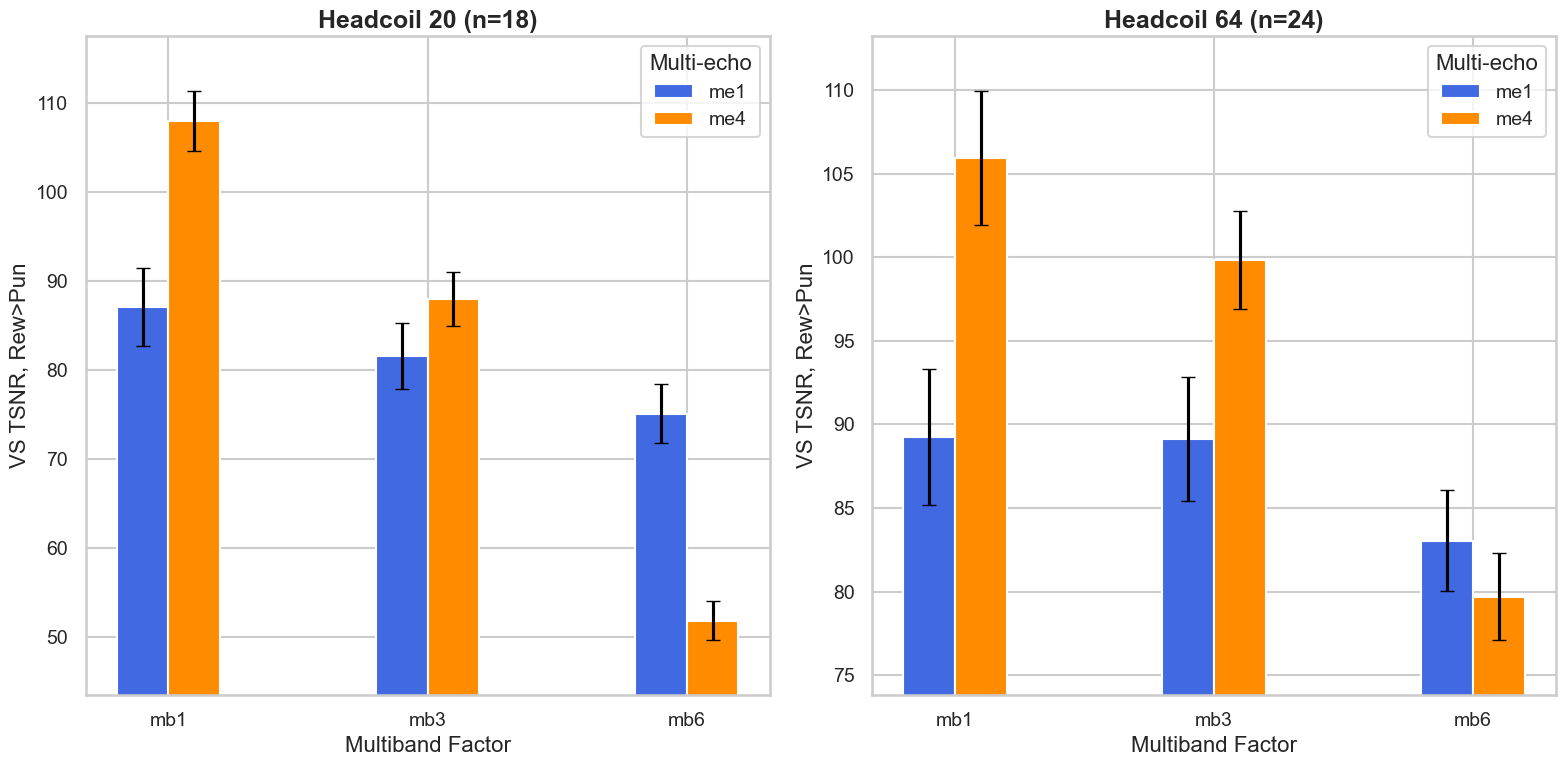

In [9]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "tsnr"  # e.g., "beta"
MASK_VALUE = "VS"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS TSNR, Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=act, img=tsnr, mask=VMPFC, denoise=base
Data saved to multiecho_data_act_tsnr_VMPFC_base.csv
Found data for 42 subjects

Sample of the data:
    subject  headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
38    10017        64   92.764439  103.486177   93.208293  111.566858   
11    10024        64   96.562068  106.675992  108.169497   97.159912   
27    10035        64  147.674807  148.346095  125.460717  132.988886   
29    10041        64  109.578625   96.607675   83.072306   65.537226   
2     10043        64  117.097093  106.711438  125.676406  124.220981   

        mb3me4      mb6me4  
38   96.743824   82.534756  
11  108.988943  105.860960  
27  127.098923  124.865261  
29   72.470341  108.679150  
2   100.134731   99.489811  

Headcoil counts:
64-channel: 24
20-channel: 18

Creating bar plots...
Plot saved as 'multiecho_plots_act_tsnr_VMPFC_base.png'


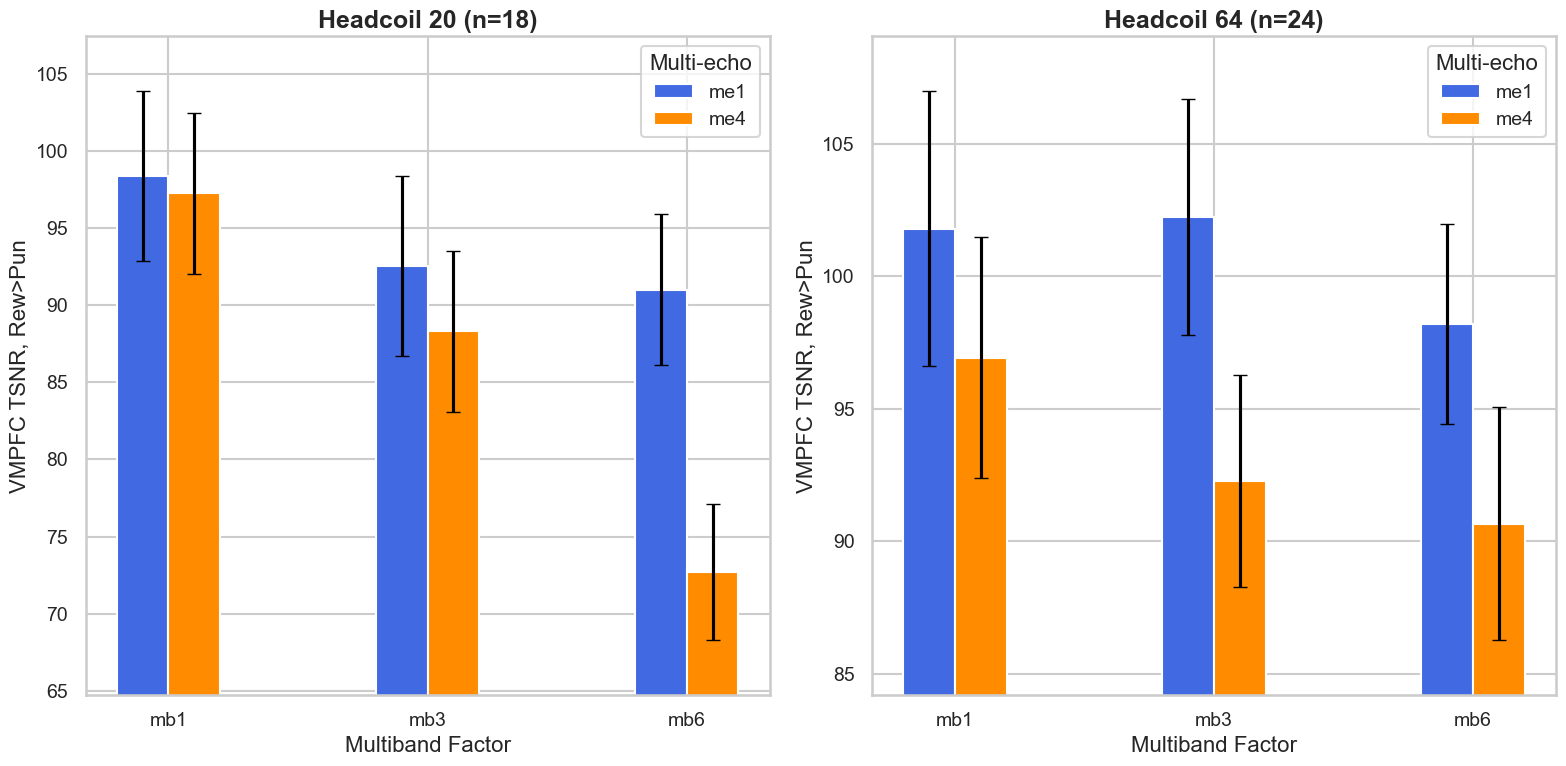

In [11]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "tsnr"  # e.g., "beta"
MASK_VALUE = "VMPFC"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC TSNR, Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [13]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "tsnr"  # e.g., "beta"
MASK_VALUE = "Motor"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('Motor TSNR, Left>Right', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

Processing files with parameters: type=act, img=tsnr, mask=Motor, denoise=base
No matching files found.


TypeError: cannot unpack non-iterable NoneType object